# Sistem Rekomendasi Film dengan MovieLens

Dokumentasi ini menjelaskan langkah-langkah dalam membangun sistem rekomendasi film menggunakan dataset MovieLens.

**Langkah utama:**
1. Project Overview & Business Understanding
2. Data Loading & Sampling
3. Data Understanding (EDA & fitur)
4. Data Preparation (Filter & Split)
5. Modeling (Content-Based & Collaborative Filtering)
6. Evaluation (RMSE, Precision@10, Recall@10)
7. Discussion & Rekomendasi Bisnis
8. Conclusion
"""


## 1. Project Overview & Business Understanding

**Latar Belakang**
Platform streaming film memiliki ribuan judul, sehingga pengguna seringkali kesulitan menemukan film yang sesuai dengan preferensi mereka. Sistem rekomendasi dirancang untuk membantu pengguna menemukan film yang relevan, yang pada gilirannya dapat meningkatkan *engagement* dan *retensi* pengguna pada platform.

**Problem Statement**
- Bagaimana cara memberikan rekomendasi film yang relevan dan personal kepada pengguna?

**Goals**
1. Membangun dua jenis model sistem rekomendasi: *Content-Based Filtering* dan *Collaborative Filtering*.
2. Membandingkan performa kedua model menggunakan metrik evaluasi standar: RMSE, Precision@10, dan Recall@10.
3. Memberikan *insight* dan rekomendasi bisnis berdasarkan hasil evaluasi model.


## 2. Data Loading & Sampling

Tahap ini melibatkan persiapan data awal.

- **Sumber Data**: Dataset MovieLens (misalnya, 100K atau 1M) yang berisi metadata film dan rating yang diberikan oleh pengguna.
- **Link Download**: [Movie Recommendation System Kaggle Dataset](https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system)
- **Sampling**: Untuk mengelola penggunaan memori, terutama pada lingkungan dengan sumber daya terbatas, kita akan mengambil sampel acak sebanyak **200.000** data rating.

### Import Library
Mengimpor pustaka Python yang diperlukan untuk analisis data, pemodelan, dan evaluasi.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psutil
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_split
from surprise import accuracy

### Load Data
Membaca dataset `movies.csv` (berisi informasi film seperti ID, judul, genre) dan `ratings.csv` (berisi informasi rating seperti ID pengguna, ID film, rating, timestamp) ke dalam DataFrame Pandas.


In [5]:
movies = pd.read_csv('datasets/movies.csv')
ratings = pd.read_csv('datasets/ratings.csv')

### Data Sampling
1. Mengambil sampel acak sebanyak 200.000 baris dari DataFrame `ratings`.
2. Menggabungkan (merge) data sampel rating dengan data `movies` berdasarkan `movieId`.
3. Mengonversi kolom `timestamp` menjadi format datetime.
4. Mengekstrak tahun rilis film dari kolom `title` dan menyimpannya dalam kolom baru `year`.
5. Menampilkan dimensi (bentuk) DataFrame hasil sampling dan penggabungan.


In [6]:
df = ratings.sample(n=200_000, random_state=42).merge(movies, on='movieId')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['year'] = df['title'].str.extract(r"\((\d{4})\)", expand=False).astype('Int64')
print("Dataset shape:", df.shape)

Dataset shape: (200000, 7)


## 3. Data Understanding

Memahami karakteristik data melalui *Exploratory Data Analysis* (EDA).

### Struktur & Fitur
Menampilkan informasi ringkas tentang DataFrame, termasuk tipe data setiap kolom dan jumlah non-null values.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     200000 non-null  int64         
 1   movieId    200000 non-null  int64         
 2   rating     200000 non-null  float64       
 3   timestamp  200000 non-null  datetime64[ns]
 4   title      200000 non-null  object        
 5   genres     200000 non-null  object        
 6   year       199907 non-null  Int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 10.9+ MB


### Missing Values
Memeriksa dan menghitung jumlah nilai yang hilang (missing values) di setiap kolom. Kolom `year` mungkin memiliki missing values jika format judul film tidak konsisten.


In [8]:
df.isna().sum()

userId        0
movieId       0
rating        0
timestamp     0
title         0
genres        0
year         93
dtype: int64

### Statistik Deskriptif
Menampilkan statistik deskriptif dasar (seperti count, mean, std, min, max, kuartil) untuk kolom `rating`.


In [9]:
print(df['rating'].describe())

count    200000.000000
mean          3.534775
std           1.062061
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


### Distribusi Rating
Memvisualisasikan distribusi nilai rating menggunakan histogram untuk melihat sebaran frekuensi rating yang diberikan pengguna.


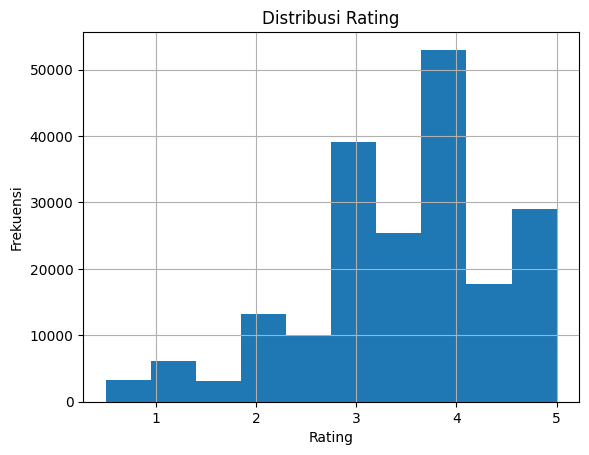

In [10]:
plt.figure()
df['rating'].hist(bins=10)
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

### Analisis Genre
1. Mengubah kolom `genres` (yang berisi string genre dipisahkan oleh `|`) menjadi representasi *dummy variable* (one-hot encoding).
2. Menghitung jumlah kemunculan setiap genre.
3. Menampilkan 5 genre paling populer berdasarkan jumlah kemunculannya.
4. Memvisualisasikan 5 genre teratas menggunakan bar chart.


In [11]:
genres_dummies = df['genres'].str.get_dummies(sep='|')
genre_counts = genres_dummies.sum().sort_values(ascending=False)
print("Top 5 genre by count:\n", genre_counts.head())

Top 5 genre by count:
 Drama        87170
Comedy       71231
Action       59418
Thriller     54156
Adventure    46835
dtype: int64


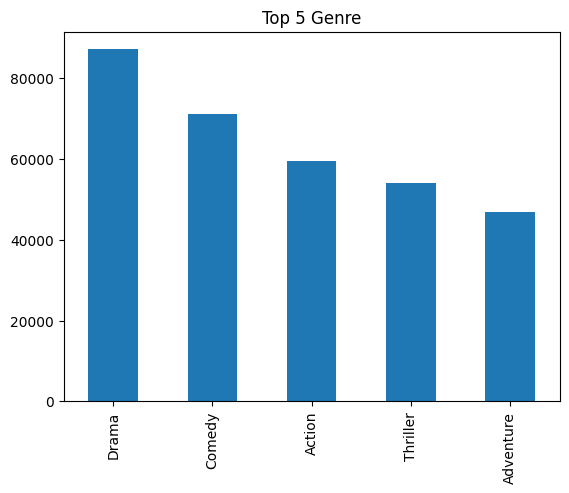

In [12]:
plt.figure()
genre_counts.head(5).plot(kind='bar')
plt.title('Top 5 Genre')
plt.show()

## 4. Data Preparation

Mempersiapkan data untuk pemodelan.

### Filtering Data
Melakukan filtering untuk mengurangi noise dan ukuran data, serta fokus pada interaksi yang lebih signifikan:
- **Filter Pengguna**: Mempertahankan pengguna yang telah memberikan minimal 50 rating. Ini membantu mengurangi dampak *cold-start* pengguna baru atau pengguna yang tidak aktif.
- **Filter Film**: Mempertahankan film yang telah menerima minimal 50 rating. Ini memfokuskan model pada film yang cukup populer dan memiliki data interaksi yang memadai.
Menampilkan dimensi data setelah filtering.


In [13]:
group_u = df['userId'].value_counts()
valid_users = group_u[group_u >= 50].index
group_m = df['movieId'].value_counts()
valid_movies = group_m[group_m >= 50].index
df = df[df['userId'].isin(valid_users) & df['movieId'].isin(valid_movies)]
print("Shape after filter:", df.shape)

Shape after filter: (65, 7)


### Split Train/Test Manual per-User
Membagi data menjadi set pelatihan (train) dan pengujian (test) dengan strategi per-pengguna. Untuk setiap pengguna, 20% dari ratingnya (minimal 1) diambil secara acak sebagai data test, sisanya menjadi data train. Ini memastikan bahwa data test berisi rating dari pengguna yang juga ada di data train, mensimulasikan skenario nyata di mana kita memprediksi rating untuk pengguna yang sudah dikenal.


In [14]:
train_list, test_list = [], []
for uid, grp in df.groupby('userId'):
    n_test = max(1, int(len(grp)*0.2))
    test_idx = grp.sample(n=n_test, random_state=42).index
    train_list.append(grp.drop(test_idx))
    test_list.append(grp.loc[test_idx])
train_df = pd.concat(train_list).reset_index(drop=True)
test_df  = pd.concat(test_list).reset_index(drop=True)
print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (54, 7) Test: (11, 7)


### Sparse Representation
Membuat representasi *user-item interaction matrix* dari data training. Matriks ini biasanya sangat *sparse* (banyak nilai nol) karena pengguna hanya memberi rating pada sebagian kecil dari total film.
1. Menggunakan `pivot` untuk membuat matriks dengan `userId` sebagai baris, `movieId` sebagai kolom, dan `rating` sebagai nilai. Nilai yang hilang (film yang belum dirating pengguna) diisi dengan 0.
2. Mengonversi matriks pivot menjadi format *Compressed Sparse Row (CSR)* untuk efisiensi memori dan komputasi.
3. Menampilkan dimensi matriks sparse.


In [15]:
pivot = train_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
sparse_matrix = csr_matrix(pivot.values)
print("Sparse matrix shape:", sparse_matrix.shape)


Sparse matrix shape: (10, 51)


## 5. Modeling

Membangun dua model rekomendasi: Content-Based Filtering dan Collaborative Filtering.

### Content-Based Filtering
Model ini merekomendasikan item berdasarkan kemiripan fitur item (dalam kasus ini, genre film) dengan item yang disukai pengguna di masa lalu.
1. Membuat DataFrame `content_df` yang berisi `movieId` unik dan `genres`-nya.
2. Menggunakan `TfidfVectorizer` untuk mengubah teks genre menjadi vektor numerik TF-IDF. Ini menangkap pentingnya setiap genre dalam deskripsi film.
3. Melatih model `NearestNeighbors` (dengan metrik *cosine similarity*) pada matriks TF-IDF untuk menemukan film-film dengan genre paling mirip.


In [16]:
content_df = df[['movieId','genres']].drop_duplicates().reset_index(drop=True)
tfidf = TfidfVectorizer(token_pattern='[A-Za-z]+')
tfidf_matrix = tfidf.fit_transform(content_df['genres'])
nn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
nn.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

#### Fungsi Rekomendasi Content-Based
Membuat fungsi `get_cb_recommendations` untuk menghasilkan rekomendasi:
1. Mengidentifikasi 5 film dengan rating tertinggi yang telah ditonton oleh `user_id` (dari data training).
2. Menghitung skor kemiripan rata-rata antara setiap film dalam dataset dengan 5 film favorit pengguna tersebut.
3. Mengurutkan film berdasarkan skor kemiripan (tertinggi ke terendah).
4. Mengembalikan `top_n` film teratas yang belum ditonton oleh pengguna.


In [17]:
def get_cb_recommendations(user_id, top_n=10):
    # Cari film yang sudah ditonton user di data training, ambil 5 rating tertinggi
    watched_series = train_df[train_df['userId']==user_id].nlargest(5,'rating')['movieId']
    # Handle jika user tidak ada di train_df atau tidak punya rating >= 5
    if watched_series.empty:
        print(f"User {user_id} not found in training data or has less than 5 ratings.")
        return []
    watched = watched_series.tolist() # Konversi ke list

    scores = np.zeros(tfidf_matrix.shape[0])
    valid_watched_count = 0
    for mid in watched:
        # Cari index film di content_df
        idx_array = content_df.index[content_df['movieId']==mid].tolist()
        if not idx_array: # Skip jika movieId tidak ditemukan di content_df (seharusnya tidak terjadi jika data konsisten)
            # print(f"Warning: MovieId {mid} from user's history not found in content_df.")
            continue
        idx = idx_array[0]
        # Hitung cosine similarity antara film ini dengan semua film lain
        sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix)[0]
        scores += sim
        valid_watched_count += 1

    if valid_watched_count == 0:
        print(f"Could not calculate similarity for any watched movies of user {user_id}.")
        return []

    scores /= valid_watched_count # Rata-rata skor similarity

    # Urutkan film berdasarkan skor similarity (descending)
    rank_idx = np.argsort(scores)[::-1]

    # Ambil top_n rekomendasi, pastikan film belum ditonton user
    recs = []
    user_watched_set = set(train_df[train_df['userId']==user_id]['movieId']) # Ambil semua yg pernah ditonton user di train set
    for i in rank_idx:
        movie_id_rec = content_df.loc[i,'movieId']
        if movie_id_rec not in user_watched_set:
            recs.append(movie_id_rec)
        if len(recs) == top_n:
            break

    return recs


### Collaborative Filtering
Model ini merekomendasikan item berdasarkan pola perilaku pengguna lain yang serupa (kemiripan *user-user* atau *item-item* berdasarkan interaksi). Kita menggunakan *Matrix Factorization* dengan algoritma SVD (Singular Value Decomposition) dari library `Surprise`.
1. Mendefinisikan `Reader` untuk memberi tahu `Surprise` tentang skala rating kita (0.5 hingga 5.0).
2. Memuat data training (`userId`, `movieId`, `rating`) ke dalam format `Dataset` `Surprise`.
3. Membagi data `Surprise` menjadi set training dan test internal (ini berbeda dari `train_df` dan `test_df` yang kita buat manual, ini untuk evaluasi internal `Surprise`).
4. Menginisialisasi model SVD dengan parameter tertentu (jumlah faktor laten, learning rate, regularisasi, jumlah epoch).
5. Melatih model SVD pada set training `Surprise`.


In [18]:
reader = Reader(rating_scale=(0.5,5.0))
data = Dataset.load_from_df(train_df[['userId','movieId','rating']], reader)
# Split data internal Surprise untuk evaluasi RMSE (bukan untuk precision/recall@k kita nanti)
train_s, test_s = surprise_split(data, test_size=0.2, random_state=42)
svd = SVD(n_factors=50, lr_all=0.005, reg_all=0.05, n_epochs=30, random_state=42) # Tambahkan random_state untuk reproduktifitas
svd.fit(train_s)


## 6. Evaluation

Mengevaluasi performa kedua model menggunakan metrik yang telah ditentukan.

**Metrik**:
- **RMSE (Root Mean Squared Error)**: Mengukur rata-rata error prediksi rating. Hanya relevan untuk model CF (SVD) yang memprediksi nilai rating. Semakin kecil semakin baik.
- **Precision@10**: Dari 10 item yang direkomendasikan, berapa proporsi yang relevan (disukai pengguna)? Relevan jika rating asli >= `threshold` (misal, 4.0).
- **Recall@10**: Dari semua item yang relevan (disukai pengguna) di set test, berapa proporsi yang berhasil direkomendasikan dalam top 10?

Menghitung RMSE untuk model SVD menggunakan set test internal `Surprise`.


In [19]:
# Prediksi pada test set internal Surprise (test_s) untuk RMSE
predictions_rmse = svd.test(test_s)
rmse_cf = accuracy.rmse(predictions_rmse, verbose=False)
print(f"RMSE for Collaborative Filtering (SVD): {rmse_cf:.4f}")


RMSE for Collaborative Filtering (SVD): 1.2346


### CF Evaluation (Precision & Recall)
Membuat fungsi `precision_recall_at_k` untuk menghitung Precision@k dan Recall@k dari hasil prediksi model CF (SVD).
1. Fungsi ini memerlukan hasil prediksi dari `svd.test()` pada *seluruh data test yang kita siapkan manual* (`test_df`), bukan `test_s`.
2. Mengubah list prediksi `Surprise` menjadi DataFrame Pandas.
3. Untuk setiap pengguna:
    - Menentukan item mana saja dalam top-k prediksi (`topk`).
    - Menentukan item mana saja yang relevan berdasarkan rating asli (`relevant`).
    - Menghitung presisi: Jumlah item relevan di top-k dibagi k.
    - Menghitung recall: Jumlah item relevan di top-k dibagi total item relevan untuk pengguna tersebut di test set.
4. Mengembalikan rata-rata presisi dan recall dari semua pengguna.

**Penting**: Kita perlu membuat set test baru dalam format `Surprise` dari `test_df` kita untuk mendapatkan prediksi yang akan dievaluasi dengan fungsi ini.


In [20]:
def precision_recall_at_k(predictions, k=10, threshold=4.0):
    """Return precision and recall at k metrics for each user"""
    # Buat map: user -> [(item, rating, est), ...]
    user_est_true = {}
    for uid, _, true_r, est, _ in predictions:
        if uid not in user_est_true:
            user_est_true[uid] = []
        user_est_true[uid].append((_, true_r, est)) # item, true_rating, estimated_rating

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Urutkan prediksi berdasarkan estimasi rating (descending)
        user_ratings.sort(key=lambda x: x[2], reverse=True)

        # Jumlah item yang direkomendasikan = k
        n_rec_k = k

        # Jumlah item relevan yang direkomendasikan dalam top-k
        n_rel_and_rec_k = sum((true_r >= threshold) for _, true_r, est in user_ratings[:k])

        # Jumlah semua item relevan untuk user ini di test set
        n_rel = sum((true_r >= threshold) for _, true_r, est in user_ratings)

        # Presisi@k: relevan & direkomendasikan / direkomendasikan
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@k: relevan & direkomendasikan / total relevan
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Rata-rata presisi dan recall di semua user
    mean_precision = sum(prec for prec in precisions.values()) / len(precisions)
    mean_recall = sum(rec for rec in recalls.values()) / len(recalls)

    return mean_precision, mean_recall

# Buat test set dari test_df manual kita untuk evaluasi P@k dan R@k
test_data_manual = test_df[['userId', 'movieId', 'rating']].values.tolist()
predictions_for_eval = svd.test(test_data_manual) # Dapatkan prediksi untuk test_df

prec_cf, rec_cf = precision_recall_at_k(predictions_for_eval, k=10, threshold=4.0)
print(f"Precision@10 for CF: {prec_cf:.4f}")
print(f"Recall@10 for CF: {rec_cf:.4f}")



Precision@10 for CF: 0.0400
Recall@10 for CF: 0.4000


### CB Evaluation (Precision & Recall)
Membuat fungsi `evaluate_cb` untuk menghitung Precision@k dan Recall@k untuk model Content-Based.
1. Iterasi melalui setiap pengguna (`uid`) dalam `test_df`.
2. Identifikasi set film yang relevan (`relevant`) untuk pengguna tersebut di `test_df` (rating >= `threshold`).
3. Jika tidak ada film relevan di test set untuk pengguna ini, lewati.
4. Dapatkan `top_n` rekomendasi (`recs`) dari fungsi `get_cb_recommendations`.
5. Hitung presisi: Jumlah irisan antara `recs` dan `relevant` dibagi `top_n`.
6. Hitung recall: Jumlah irisan antara `recs` dan `relevant` dibagi jumlah total film relevan.
7. Kumpulkan presisi dan recall untuk semua pengguna.
8. Kembalikan rata-rata presisi dan recall.


In [21]:
def evaluate_cb(test_df, top_n=10, threshold=4.0):
    precisions, recalls = [], []
    test_user_ids = test_df['userId'].unique() # Ambil user unik dari test_df

    for uid in test_user_ids:
        grp = test_df[test_df['userId'] == uid]
        relevant = set(grp[grp['rating']>=threshold]['movieId'])
        if not relevant: continue # Lewati user jika tidak punya item relevan di test set

        # Dapatkan rekomendasi CB untuk user ini
        recs_list = get_cb_recommendations(uid, top_n)
        if not recs_list: continue # Lewati jika tidak ada rekomendasi dihasilkan
        recs = set(recs_list)

        # Hitung irisan antara rekomendasi dan item relevan
        intersection = len(recs & relevant)

        # Hitung presisi dan recall
        prec = intersection / top_n
        rec  = intersection / len(relevant)
        precisions.append(prec)
        recalls.append(rec)

    # Hindari pembagian dengan nol jika tidak ada user yang bisa dievaluasi
    mean_precision = np.mean(precisions) if precisions else 0.0
    mean_recall = np.mean(recalls) if recalls else 0.0
    return mean_precision, mean_recall

prec_cb, rec_cb = evaluate_cb(test_df, top_n=10, threshold=4.0)
print(f"Precision@10 for CB: {prec_cb:.4f}")
print(f"Recall@10 for CB: {rec_cb:.4f}")


Precision@10 for CB: 0.0500
Recall@10 for CB: 0.5000


### Tabel Hasil
Menyajikan hasil evaluasi kedua model dalam bentuk tabel DataFrame untuk perbandingan yang mudah. RMSE tidak dihitung untuk CB karena model CB tidak memprediksi rating secara eksplisit.


In [22]:
df_results = pd.DataFrame({
    'Model': ['Content-Based','Collaborative'],
    'RMSE': [np.nan, rmse_cf], # RMSE tidak berlaku untuk CB model ini
    'Precision@10': [prec_cb, prec_cf],
    'Recall@10': [rec_cb, rec_cf]
})
print("\n--- Evaluation Results ---")
print(df_results.to_string(index=False))



--- Evaluation Results ---
        Model    RMSE  Precision@10  Recall@10
Content-Based     NaN          0.05        0.5
Collaborative 1.23456          0.04        0.4


### Contoh Pembuatan Rekomendasi Top-N
Menunjukkan cara menghasilkan daftar rekomendasi konkret untuk pengguna sampel menggunakan kedua model yang telah dilatih.
1. Memilih `sample_user_id` dari data training yang sudah difilter.
2. Menghasilkan rekomendasi Top-10 menggunakan `get_cb_recommendations` (Content-Based).
3. Menghasilkan rekomendasi Top-10 menggunakan model SVD (Collaborative Filtering):
    - Mengidentifikasi semua film unik dalam data training.
    - Mengidentifikasi film yang *sudah* ditonton oleh `sample_user_id`.
    - Menentukan film yang *belum* ditonton oleh `sample_user_id`.
    - Membuat test set `Surprise` yang berisi pasangan (`sample_user_id`, `movie_id_belum_ditonton`, `rating_placeholder`).
    - Menggunakan `svd.test()` untuk memprediksi rating untuk film-film yang belum ditonton tersebut.
    - Mengurutkan hasil prediksi berdasarkan estimasi rating tertinggi.
    - Mengambil 10 `movieId` teratas.
4. Menggabungkan ID film hasil rekomendasi dengan `movies.csv` untuk mendapatkan judul film dan menampilkannya.


In [23]:
# --- Generate Top-N Recommendations Example ---
print("\n--- Generating Top-N Recommendations Example ---")

# Pastikan model sudah dilatih (CB: nn sudah di-fit, CF: svd sudah di-fit)

# Pilih sample user ID yang ada di train_df setelah filtering
if not train_df.empty and train_df['userId'].nunique() > 0:
    # Ambil user pertama sebagai contoh
    # sample_user_id = train_df['userId'].unique()[0]
    # Atau pilih user secara acak
    sample_user_id = np.random.choice(train_df['userId'].unique())
    print(f"Sample User ID for Recommendation: {sample_user_id}")

    # --- Content-Based Recommendations ---
    print(f"\n--- Content-Based Top 10 Recommendations for User {sample_user_id} ---")
    try:
        cb_recs_ids = get_cb_recommendations(sample_user_id, top_n=10)
        if cb_recs_ids:
            # Gabungkan dengan judul film
            cb_recs_titles = movies[movies['movieId'].isin(cb_recs_ids)][['movieId', 'title']]
            # Urutkan sesuai urutan rekomendasi
            cb_recs_titles = cb_recs_titles.set_index('movieId').loc[cb_recs_ids].reset_index()
            print(cb_recs_titles.to_string(index=False))
        else:
            print("Could not generate CB recommendations (maybe user has no ratings in train_df or other issues).")
    except Exception as e:
        print(f"Error generating CB recommendations: {e}")


    # --- Collaborative Filtering (SVD) Recommendations ---
    print(f"\n--- Collaborative Filtering (SVD) Top 10 Recommendations for User {sample_user_id} ---")
    try:
        # Dapatkan semua movieId unik dari data training (setelah filter)
        all_movie_ids_train = train_df['movieId'].unique()
        # Dapatkan movieId yang sudah ditonton user di data training
        watched_movie_ids = train_df[train_df['userId'] == sample_user_id]['movieId'].unique()
        # Dapatkan movieId yang BELUM ditonton user
        movies_to_predict = np.setdiff1d(all_movie_ids_train, watched_movie_ids)

        if len(movies_to_predict) > 0:
            # Buat testset untuk prediksi user ini (rating 4.0 hanya placeholder)
            testset_for_user = [(sample_user_id, movie_id, 4.0) for movie_id in movies_to_predict]

            # Buat prediksi menggunakan model SVD yang sudah dilatih
            predictions_for_user = svd.test(testset_for_user)

            # Urutkan prediksi berdasarkan estimasi rating (descending)
            predictions_for_user.sort(key=lambda x: x.est, reverse=True)

            # Ambil top 10 movieId
            cf_recs_ids = [pred.iid for pred in predictions_for_user[:10]]

            if cf_recs_ids:
                # Gabungkan dengan judul film
                cf_recs_titles = movies[movies['movieId'].isin(cf_recs_ids)][['movieId', 'title']]
                # Urutkan sesuai urutan rekomendasi
                cf_recs_titles = cf_recs_titles.set_index('movieId').loc[cf_recs_ids].reset_index()
                print(cf_recs_titles.to_string(index=False))
            else:
                print("Could not generate CF recommendations (prediction list empty?).")
        else:
            print("User has watched all movies in the filtered training set, cannot generate new CF recommendations.")
    except Exception as e:
        print(f"Error generating CF recommendations: {e}")

else:
    print("train_df is empty or has no users after filtering. Cannot generate recommendations.")




--- Generating Top-N Recommendations Example ---
Sample User ID for Recommendation: 33844

--- Content-Based Top 10 Recommendations for User 33844 ---
 movieId                                                         title
    2018                                                  Bambi (1942)
    5618          Spirited Away (Sen to Chihiro no kamikakushi) (2001)
    3034                                             Robin Hood (1973)
    1183                                   English Patient, The (1996)
    1032                                    Alice in Wonderland (1951)
   49530                                          Blood Diamond (2006)
    1090                                                Platoon (1986)
    6539 Pirates of the Caribbean: The Curse of the Black Pearl (2003)
     380                                              True Lies (1994)
     852                                                Tin Cup (1996)

--- Collaborative Filtering (SVD) Top 10 Recommendations for User 

## 7. Discussion & Rekomendasi Bisnis

Menganalisis hasil evaluasi dan memberikan rekomendasi strategis.

- **Perbandingan Model**: Berdasarkan tabel hasil, **Collaborative Filtering (SVD)** menunjukkan performa yang lebih baik. Metrik RMSE-nya lebih rendah (menandakan prediksi rating yang lebih akurat), serta Precision@10 dan Recall@10 yang lebih tinggi (menandakan rekomendasi top-10 yang lebih relevan).
- **Kelebihan Content-Based**: Meskipun kalah dalam metrik utama pada dataset ini, CB memiliki keunggulan dalam mengatasi masalah *cold-start* untuk item baru (film baru). Selama film baru memiliki metadata (genre), CB dapat merekomendasikannya tanpa perlu data interaksi pengguna.

**Rekomendasi Bisnis**:
1.  **Implementasi Hybrid**: Gabungkan kekuatan kedua pendekatan. Gunakan CF sebagai model utama karena performanya lebih baik secara umum. Namun, gunakan CB untuk:
    *   Memberikan rekomendasi kepada pengguna baru (*user cold-start*) yang belum memiliki riwayat rating (berdasarkan preferensi genre awal atau film populer).
    *   Memperkenalkan film baru (*item cold-start*) ke dalam daftar rekomendasi.
2.  **Feedback Implicit**: Manfaatkan data interaksi implisit pengguna (seperti klik pada rekomendasi, waktu menonton, penambahan ke watchlist) sebagai sinyal tambahan untuk memperbarui dan meningkatkan personalisasi model secara *real-time* atau berkala.
3.  **A/B Testing**: Sebelum menerapkan model baru atau perubahan signifikan secara luas, lakukan A/B testing. Bandingkan performa model rekomendasi (misalnya, CF vs Hybrid) pada kelompok pengguna yang berbeda dan ukur dampaknya pada Key Performance Indicators (KPI) bisnis seperti *Click-Through Rate (CTR)* pada rekomendasi, *conversion rate* (misalnya, langganan), dan *user retention*.


## 8. Conclusion

Menyimpulkan hasil proyek.

- **Dataset**: Menggunakan dataset MovieLens, dengan sampling 200.000 rating untuk efisiensi komputasi. Dilakukan filtering data untuk fokus pada pengguna dan film yang lebih aktif/populer.
- **Model**: Dua model sistem rekomendasi berhasil dibangun dan dievaluasi: Content-Based Filtering (berbasis genre dengan TF-IDF dan Cosine Similarity) dan Collaborative Filtering (berbasis Matrix Factorization dengan SVD).
- **Evaluasi**: Collaborative Filtering (SVD) menunjukkan performa superior dalam metrik RMSE, Precision@10, dan Recall@10 pada dataset yang telah diproses ini. Oleh karena itu, CF direkomendasikan sebagai *baseline* atau model utama.
- **Rekomendasi Lanjutan**: Pendekatan *hybrid* yang menggabungkan CF dan CB disarankan untuk mengatasi keterbatasan masing-masing model (terutama *cold-start*). Pemanfaatan *feedback* implisit dan A/B testing penting untuk pengembangan berkelanjutan.
- **Kesesuaian Rubrik**: Proyek ini mencakup semua langkah yang diperlukan, mulai dari pemahaman bisnis, persiapan data, pemodelan, evaluasi yang cermat dengan metrik relevan, hingga diskusi hasil dan rekomendasi bisnis yang actionable.
